In [4]:
PRE_TRAINED = False
MODEL1_PATH = '5_1_1.h5'
MODEL2_PATH = '5_1_2.h5'
if PRE_TRAINED:
    import gdown
    gdown.download(
        'https://drive.google.com/uc?id=15QZGhjiBDCn9PyotrIT5i4hspBxWSI9s',
        MODEL1_PATH,
        quiet=False
    )
    gdown.download(
        'https://drive.google.com/uc?id=1Olsw2Bmw2jQbYGd0mFD9LlRfM4F097SO',
        MODEL2_PATH,
        quiet=False
    )

# Convolutional autoencoder for image denoising

**Author:** [Santiago L. Valdarrama](https://twitter.com/svpino)<br>
**Date created:** 2021/03/01<br>
**Last modified:** 2021/03/01<br>
**Description:** How to train a deep convolutional autoencoder for image denoising.

## Introduction

This example demonstrates how to implement a deep convolutional autoencoder
for image denoising, mapping noisy digits images from the MNIST dataset to
clean digits images. This implementation is based on an original blog post
titled [Building Autoencoders in Keras](https://blog.keras.io/building-autoencoders-in-keras.html)
by [François Chollet](https://twitter.com/fchollet).

## Setup

In [5]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from tensorflow.keras import layers
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Model


def preprocess(array):
    """
    Normalizes the supplied array and reshapes it into the appropriate format.
    """

    array = array.astype("float32") / 255.0
    array = np.reshape(array, (len(array), 28, 28, 1))
    return array


def noise(array):
    """
    Adds random noise to each image in the supplied array.
    """

    noise_factor = 0.4
    noisy_array = array + noise_factor * np.random.normal(
        loc=0.0, scale=1.0, size=array.shape
    )

    return np.clip(noisy_array, 0.0, 1.0)


def display(array1, array2):
    """
    Displays ten random images from each one of the supplied arrays.
    """

    n = 10

    indices = np.random.randint(len(array1), size=n)
    images1 = array1[indices, :]
    images2 = array2[indices, :]

    plt.figure(figsize=(20, 4))
    for i, (image1, image2) in enumerate(zip(images1, images2)):
        ax = plt.subplot(2, n, i + 1)
        plt.imshow(image1.reshape(28, 28))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        ax = plt.subplot(2, n, i + 1 + n)
        plt.imshow(image2.reshape(28, 28))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

    plt.show()


## Prepare the data

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


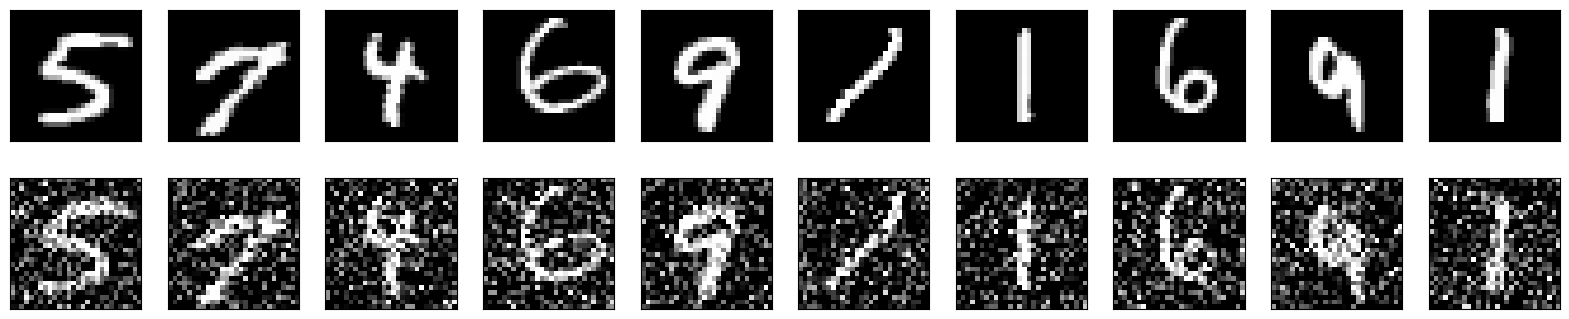

In [6]:
# Since we only need images from the dataset to encode and decode, we
# won't use the labels.
(train_data, _), (test_data, _) = mnist.load_data()

# Normalize and reshape the data
train_data = preprocess(train_data)
test_data = preprocess(test_data)

# Create a copy of the data with added noise
noisy_train_data = noise(train_data)
noisy_test_data = noise(test_data)

# Display the train data and a version of it with added noise
display(train_data, noisy_train_data)

## Build the autoencoder

We are going to use the Functional API to build our convolutional autoencoder.

In [7]:
input = layers.Input(shape=(28, 28, 1))

# ----- Encoder -----
x = layers.Conv2D(32, (3, 3), padding="same")(input)
x = layers.BatchNormalization()(x)
x = layers.Activation("relu")(x)
x = layers.MaxPooling2D((2, 2), padding="same")(x)

x = layers.Conv2D(32, (3, 3), padding="same")(x)
x = layers.BatchNormalization()(x)
x = layers.Activation("relu")(x)
x = layers.MaxPooling2D((2, 2), padding="same")(x)

# ----- Decoder -----
x = layers.Conv2DTranspose(32, (3, 3), strides=2, padding="same")(x)
x = layers.BatchNormalization()(x)
x = layers.Activation("relu")(x)

x = layers.Conv2DTranspose(32, (3, 3), strides=2, padding="same")(x)
x = layers.BatchNormalization()(x)
x = layers.Activation("relu")(x)

x = layers.Conv2D(1, (3, 3), activation="sigmoid", padding="same")(x)

def psnr_metric(y_true, y_pred):
    return tf.image.psnr(y_true, y_pred, max_val=1.0)

autoencoder = Model(input, x)

autoencoder.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss="binary_crossentropy",
    metrics=["mse", psnr_metric]
)

autoencoder.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 28, 28, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 28, 28, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 28, 28, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 28, 28, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 14, 14, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 14, 14, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 7, 7, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose                │ (None, 14, 14, 32)     │         9,248 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 14, 14, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_1              │ (None, 28, 28, 32)     │         9,248 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 28, 28, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_3 (Activation)       │ (None, 28, 28, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 28, 28, 1)      │           289 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 28,865 (112.75 KB)

 Trainable params: 28,609 (111.75 KB)

 Non-trainable params: 256 (1.00 KB)

Now we can train our autoencoder using `train_data` as both our input data
and target. Notice we are setting up the validation data using the same
format.

In [8]:
import time

early_stop = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",        # monitor validation loss
    patience=5,                # stop after 5 epochs without improvement
    restore_best_weights=True  # restore best model
)

start_time = time.time()

if PRE_TRAINED:
    autoencoder = tf.keras.models.load_model(MODEL1_PATH)
else:
      history = autoencoder.fit(
        x=noisy_train_data,
        y=train_data,
        epochs=100,
        batch_size=128,
        shuffle=True,
        validation_data=(noisy_test_data, test_data),
        callbacks=[early_stop]
    )
autoencoder.save(MODEL1_PATH)

end_time = time.time()

print("Total training time: {:.2f} seconds".format(end_time - start_time))
print("Average time per epoch: {:.2f} seconds".format((end_time - start_time)/100))

Epoch 1/100
469/469 ━━━━━━━━━━━━━━━━━━━━ 17s 19ms/step - loss: 0.1536 - mse: 0.0276 - psnr_metric: 17.5812 - val_loss: 0.1046 - val_mse: 0.0136 - val_psnr_metric: 18.9351
Epoch 2/100
469/469 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - loss: 0.0908 - mse: 0.0092 - psnr_metric: 20.6811 - val_loss: 0.0881 - val_mse: 0.0085 - val_psnr_metric: 21.0286
Epoch 3/100
469/469 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - loss: 0.0883 - mse: 0.0085 - psnr_metric: 21.0395 - val_loss: 0.0868 - val_mse: 0.0081 - val_psnr_metric: 21.2415
Epoch 4/100
469/469 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - loss: 0.0871 - mse: 0.0081 - psnr_metric: 21.2288 - val_loss: 0.0860 - val_mse: 0.0078 - val_psnr_metric: 21.3735
Epoch 5/100
469/469 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - loss: 0.0863 - mse: 0.0079 - psnr_metric: 21.3439 - val_loss: 0.0859 - val_mse: 0.0078 - val_psnr_metric: 21.3927
Epoch 6/100
469/469 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - loss: 0.0859 - mse: 0.0078 - psnr_metric: 21.4193 - val_loss: 0.0852 - val_mse: 0.0076 - val_psnr_

Total training time: 171.53 seconds
Average time per epoch: 1.72 seconds


Let's predict on our test dataset and display the original image together with
the prediction from our autoencoder.

Notice how the predictions are pretty close to the original images, although
not quite the same.

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


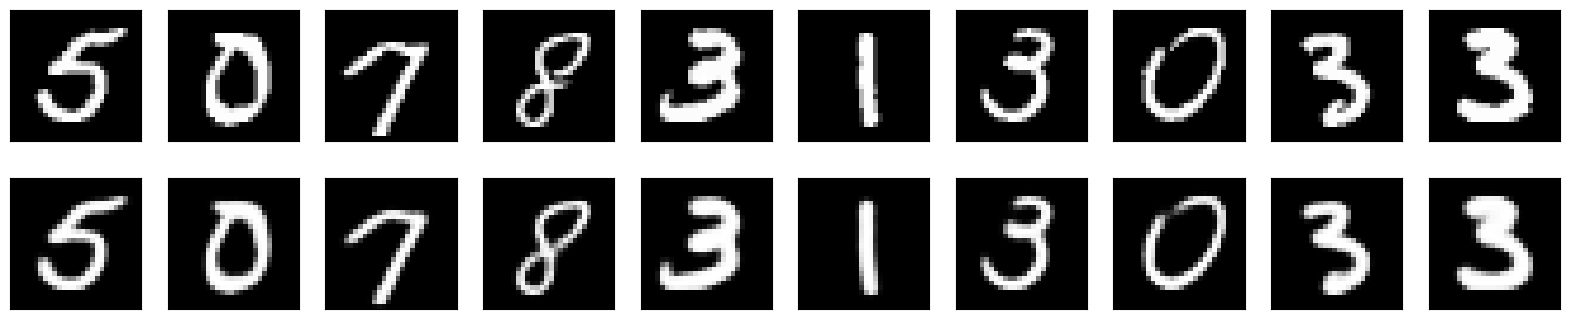

In [9]:
predictions = autoencoder.predict(test_data)
display(test_data, predictions)

Now that we know that our autoencoder works, let's retrain it using the noisy
data as our input and the clean data as our target. We want our autoencoder to
learn how to denoise the images.

In [10]:
start_time = time.time()

if PRE_TRAINED:
    autoencoder = tf.keras.models.load_model(MODEL2_PATH)
else:
    history = autoencoder.fit(
        x=noisy_train_data,
        y=train_data,
        epochs=100,
        batch_size=128,
        shuffle=True,
        validation_data=(noisy_test_data, test_data),
        callbacks=[early_stop]
    )
    autoencoder.save(MODEL2_PATH)

end_time = time.time()

print("Total training time: {:.2f} seconds".format(end_time - start_time))
print("Average time per epoch: {:.2f} seconds".format((end_time - start_time)/100))


Epoch 1/100
469/469 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - loss: 0.0835 - mse: 0.0071 - psnr_metric: 21.8185 - val_loss: 0.0842 - val_mse: 0.0074 - val_psnr_metric: 21.6541
Epoch 2/100
469/469 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - loss: 0.0834 - mse: 0.0071 - psnr_metric: 21.8216 - val_loss: 0.0835 - val_mse: 0.0071 - val_psnr_metric: 21.7862
Epoch 3/100
469/469 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - loss: 0.0834 - mse: 0.0071 - psnr_metric: 21.8312 - val_loss: 0.0834 - val_mse: 0.0071 - val_psnr_metric: 21.8079
Epoch 4/100
469/469 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - loss: 0.0837 - mse: 0.0071 - psnr_metric: 21.8146 - val_loss: 0.0837 - val_mse: 0.0072 - val_psnr_metric: 21.7675
Epoch 5/100
469/469 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - loss: 0.0837 - mse: 0.0071 - psnr_metric: 21.8131 - val_loss: 0.0834 - val_mse: 0.0071 - val_psnr_metric: 21.8149
Epoch 6/100
469/469 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - loss: 0.0836 - mse: 0.0071 - psnr_metric: 21.8315 - val_loss: 0.0833 - val_mse: 0.0071 - val_psnr_me

Total training time: 95.08 seconds
Average time per epoch: 0.95 seconds


Let's now predict on the noisy data and display the results of our autoencoder.

Notice how the autoencoder does an amazing job at removing the noise from the
input images.

313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Final Test MSE: 0.007050816
Average PSNR: 21.842997


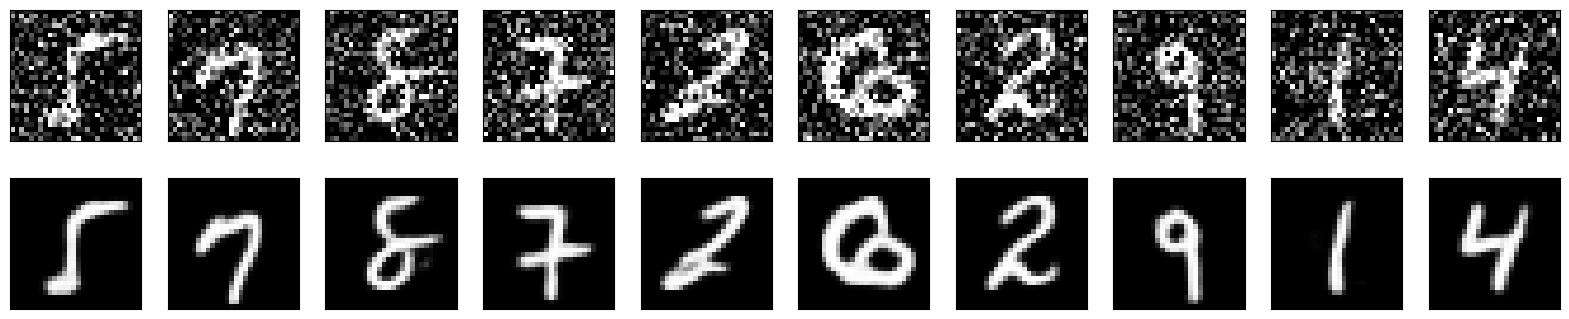

In [11]:
from sklearn.metrics import mean_squared_error

predictions = autoencoder.predict(noisy_test_data)

mse = np.mean(np.square(test_data - predictions))
psnr = tf.image.psnr(test_data, predictions, max_val=1.0)

print("Final Test MSE:", mse)
print("Average PSNR:", np.mean(psnr.numpy()))


display(noisy_test_data, predictions)

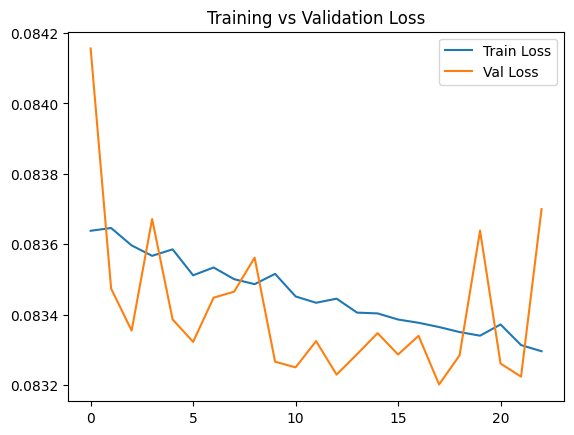

In [12]:
import matplotlib.pyplot as plt

plt.plot(history.history["loss"], label="Train Loss")
plt.plot(history.history["val_loss"], label="Val Loss")
plt.legend()
plt.title("Training vs Validation Loss")
plt.show()
